In [47]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary
from PIL import ImageOps
import random
import torch.functional as F


import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from pathlib import Path

import numpy as np

# device = "cuda"
device= "mps"

In [48]:
class Solarization(object):
    """
    Apply Solarization to the PIL image.
    """
    def __init__(self, p):
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            img = transforms.ToPILImage(img)
            return transforms.ToTensor(ImageOps.solarize(img))
        else:
            return img

# Dataset : Fashion MNIST

In [50]:
train_data = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [51]:
train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
test_dl = DataLoader(test_data, batch_size=64, shuffle=False)

dummy = next(iter(train_dl))[0]

tensor(1.)

In [35]:
# plot 3x3 images in train set

def plot(images, labels, names):
    fig, axes = plt.subplots(3, 3, figsize=(7, 7))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
        ax.set_title(names[labels[i].item()], fontsize=14)

    plt.show()

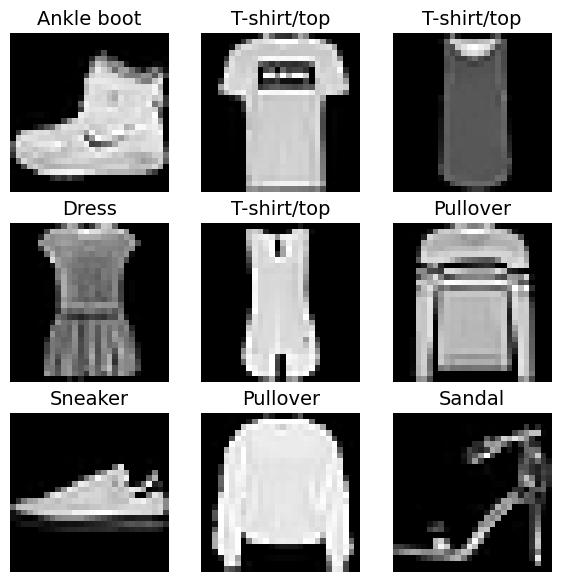

In [36]:
plot(images=train_data.data[:9], labels=train_data.targets[:9], names=train_data.classes)

transforming= RandomResizedCrop(size=(28, 28), scale=(0.5, 0.99), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
x1.shape_  torch.Size([1, 28, 28])


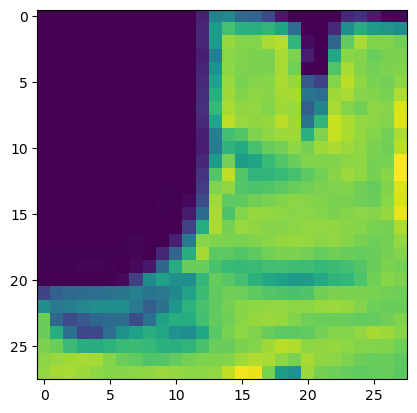

In [66]:
transforming = transforms.RandomResizedCrop(size=(28, 28), scale=(0.5, 0.99), ratio=(3/4, 4/3), interpolation=2)
x1= dummy[3]
print("transforming=", transforming)
print("x1.shape_ ", x1.shape)

plt.imshow(transforming(x1).squeeze())

# 1 - Construction du modèle

Le modèle est un ViT. Réimplémentons donc les ViT

In [67]:
class MSA(nn.Module):
    """ Implement multi-headed self-attention."""
    def __init__(self, dim_embedding, n_heads, dh=None) -> None:
        super().__init__()
        self.dim_embedding = dim_embedding
        self.n_heads = n_heads
        self.dh = dh or dim_embedding // n_heads
        self.qkv = nn.Linear(dim_embedding, 3 * (n_heads * self.dh))
        self.merge = nn.Linear(n_heads * self.dh, dim_embedding)
        
    def forward(self, x):
        batch_size, seq_length, _ = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.chunk(3, dim=-1)
        
        q = q.view(batch_size, seq_length, self.n_heads, self.dh).transpose(1, 2)
        k = k.view(batch_size, seq_length, self.n_heads, self.dh).transpose(1, 2)
        v = v.view(batch_size, seq_length, self.n_heads, self.dh).transpose(1, 2)
        
        A = torch.softmax(torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.dh, dtype=torch.float32)), dim=-1)
        out = torch.matmul(A, v)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_length, -1)
        return self.merge(out)

class MLP(nn.Module):
    def __init__(self, dim_embedding) -> None:
        super().__init__()
        self.fc1 = nn.Linear(dim_embedding, 4*dim_embedding)
        self.fc2 = nn.Linear(4*dim_embedding, dim_embedding)
        self.activation = nn.GELU()

    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        return self.fc2(x)



class Block(nn.Module):
    def __init__(self, dim_embedding, n_heads, dh=None):
        super().__init__()
        self.MSAH = MSA(dim_embedding, n_heads, dh)
        self.MLP = MLP(dim_embedding)
        self.layer_norm1 = nn.LayerNorm(dim_embedding)
        self.layer_norm2 = nn.LayerNorm(dim_embedding)

    def forward(self, x):
        x = self.layer_norm1(x)
        x = x + self.MSAH(x)
        x = self.layer_norm2(x)
        x = self.MLP(x) + x
        return x

class PatchEmbed(nn.Module):

    def __init__(self, dim_embedding, patch_size, num_patches=None, channels = 1):
        super().__init__()
        num_patches = num_patches or (28 // patch_size)**2
        self.conv = nn.Conv2d(channels, dim_embedding, kernel_size=patch_size, stride=patch_size)

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim_embedding))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches+1, dim_embedding))

    def forward(self, x):
        B, C, H, W = x.shape
        x = torch.flatten(self.conv(x), start_dim = 2).permute(0, 2, 1)
        
        cls = self.cls_token.repeat(B, 1, 1)
        pos_embedding = self.pos_embedding.repeat(B, 1, 1)

        x = torch.cat([cls, x], dim=1) + pos_embedding
        return x
    
    # def interpolate_pos_encoding(self, x, w, h):
    #     npatch = x.shape[1] - 1
    #     N = self.pos_embed.shape[1] - 1
    #     if npatch == N and w == h:
    #         return self.pos_embed
    #     class_pos_embed = self.pos_embed[:, 0]
    #     patch_pos_embed = self.pos_embed[:, 1:]
    #     dim = x.shape[-1]
    #     w0 = w // self.patch_embed.patch_size
    #     h0 = h // self.patch_embed.patch_size
    #     # we add a small number to avoid floating point error in the interpolation
    #     # see discussion at https://github.com/facebookresearch/dino/issues/8
    #     w0, h0 = w0 + 0.1, h0 + 0.1
    #     patch_pos_embed = nn.functional.interpolate(
    #         patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
    #         scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
    #         mode='bicubic',
    #     )
    #     assert int(w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
    #     patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
    #     return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    
class ProjectionHead(nn.Module):
    def __init__(self, dim_embedding, hidden_dim, num_classes):
        super().__init__()
        self.MLP = nn.Sequential(nn.LayerNorm(dim_embedding),
                                 nn.Linear(dim_embedding, hidden_dim), 
                                 nn.GELU(), 
                                #  nn.Linear(hidden_dim, hidden_dim),
                                #  nn.GELU()
                                 )
        self.last_layer= nn.utils.weight_norm(nn.Linear(hidden_dim, num_classes, bias=False))
        self.last_layer.weight_g.data.fill_(1)
    
    def forward(self, x):
        x = self.MLP(x)
        return self.last_layer(x)


In [166]:
class VisionTransformer(nn.Module):
    def __init__(self, dim_embedding, n_heads, patch_size, n_blocks, n_hidden, n_out, dh=None, num_patches=None, channels=1):
        super().__init__()
        self.embedding = PatchEmbed(dim_embedding, patch_size, num_patches, channels)
        self.blocks = nn.Sequential(*nn.ModuleList([Block(dim_embedding, n_heads, dh) for _ in range(n_blocks)]))
        self.projection_head = ProjectionHead(dim_embedding, n_hidden, n_out)

    def forward(self, x):
        X = self.embedding(x)
        X = self.blocks(X)
        return self.projection_head(X[:, 0])
        
    def embed(self, x):
        return self.embedding(x)

    def extract_features(self, x):
        return self.blocks(self.embedding(x))
    
    @property
    def extract_DINO(self):
        return nn.Sequential(self.embedding, self.blocks)
        

In [69]:
# testing
vit = VisionTransformer(dim_embedding=64, n_heads=8, patch_size=4, n_blocks=6, n_hidden=512, n_out=100)
dummy_embed = vit.embed(dummy)
print(vit(dummy))

summary(vit, input_size=(64, 1, 28, 28))

tensor([[-6.8182e-01,  9.7794e-03,  6.0374e-03,  ...,  5.3317e-01,
          3.9382e-01, -4.4896e-01],
        [-6.8183e-01,  1.3863e-02, -8.1835e-03,  ...,  5.3599e-01,
          3.8943e-01, -4.4907e-01],
        [-6.9992e-01,  2.1960e-02, -2.1304e-02,  ...,  5.1443e-01,
          3.9366e-01, -4.7343e-01],
        ...,
        [-6.7463e-01,  2.6304e-02,  8.3353e-03,  ...,  5.5956e-01,
          3.8688e-01, -4.1835e-01],
        [-6.7233e-01,  7.2189e-03,  1.4513e-02,  ...,  5.4509e-01,
          3.8770e-01, -4.3725e-01],
        [-6.6078e-01,  5.5387e-04,  2.6267e-02,  ...,  5.6289e-01,
          3.7421e-01, -4.1547e-01]], grad_fn=<MmBackward0>)


/opt/homebrew/anaconda3/envs/headmind/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [64, 100]                 --
├─PatchEmbed: 1-1                        [64, 50, 64]              3,264
│    └─Conv2d: 2-1                       [64, 64, 7, 7]            1,088
├─Sequential: 1-2                        [64, 50, 64]              --
│    └─Block: 2-2                        [64, 50, 64]              --
│    │    └─LayerNorm: 3-1               [64, 50, 64]              128
│    │    └─MSA: 3-2                     [64, 50, 64]              16,640
│    │    └─LayerNorm: 3-3               [64, 50, 64]              128
│    │    └─MLP: 3-4                     [64, 50, 64]              33,088
│    └─Block: 2-3                        [64, 50, 64]              --
│    │    └─LayerNorm: 3-5               [64, 50, 64]              128
│    │    └─MSA: 3-6                     [64, 50, 64]              16,640
│    │    └─LayerNorm: 3-7               [64, 50, 64]           

# 2 - Build crops (large and small)

Methodology : 

Build large and small crops of the image with data augmentations.
- 2 large crops : $x_g1$ and $x_g2$
- k small crops : __TO DO__ : Update the positionnal and patch embedding, do split

In [83]:
# from typing import Any


# class DataAugmentation:
#     def __init__(self, global_crops_scale, local_crops_scale, local_crops_number, large_crop_size=28) -> None:
#         col_jit = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)
        
#         flip_and_color_jitter= transforms.Compose(
#             transforms.RandomHorizontalFlip(p=0.5),
#             transforms.RandomApply(col_jit ,p=0.8),
#             transforms.RandomGrayscale(p=0.2))
        
#         normalize = transforms.Compose(
#             transforms.ToTensor(),
#             transforms.Normalize(0.456, 0.225)
#         )

#         self.global_transform1 = transforms.Compose(
#                         transforms.RandomResizedCrop(large_crop_size, scale=global_crops_scale, interpolation=2),
#             flip_and_color_jitter,
#             # no gaussian blur, bad enough quality...
#             normalize
#         )
        
#         self.global_transform2 = transforms.Compose(
#             transforms.RandomResizedCrop(large_crop_size, scale=global_crops_scale, interpolation=2),
#             flip_and_color_jitter,
#             # no gaussian blur, bad enough quality...
#             Solarization(p=0.2),
#             normalize
#         )

#         self.local_crops_number = local_crops_number
#         self.local_transfo = transforms.Compose([
#             transforms.RandomResizedCrop(4, scale=local_crops_scale, interpolation=Image.BICUBIC),
#             flip_and_color_jitter,
#             normalize,
#         ])

#     def __call__(self, *args: Any, **kwds: Any) ->:

class DataAugLarge:
    def __init__(self, global_crops_scale, large_crop_size=28) -> None:
        
        flip_and_color_jitter= transforms.Compose(
            [
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)]
                        ,p=0.8),
            ])
        
        # normalize = transforms.Compose(
        #     [
        #         transforms.ToTensor(),
        #         # ToDtype(dtype=torch.float32),
        #         transforms.Normalize(0.456, 0.225)
        #     ]
        # )
        normalize = transforms.Normalize(0.456, 0.225)

        self.global_transform1 = transforms.Compose(
                        [transforms.RandomResizedCrop(large_crop_size, scale=global_crops_scale, interpolation=2),
            flip_and_color_jitter,
            # no gaussian blur, bad enough quality...
            normalize
            ]
        )
        
        self.global_transform2 = transforms.Compose(
            [transforms.RandomResizedCrop(large_crop_size, scale=global_crops_scale, interpolation=2),
            flip_and_color_jitter,
            # no gaussian blur, bad enough quality...
            Solarization(p=0.2),
            normalize]
        )

        # self.local_crops_number = local_crops_number
        # self.local_transfo = transforms.Compose([
        #     transforms.RandomResizedCrop(4, scale=local_crops_scale, interpolation=Image.BICUBIC),
        #     flip_and_color_jitter,
        #     normalize,
        # ])



    def __call__(self, x):
        x = x #images are in Black&White, add a dim for the channels
        return self.global_transform1(x), self.global_transform2(x)
        

In [84]:
trans = DataAugLarge(large_crop_size=(28, 28), global_crops_scale=(0.5, 1.0))

In [90]:
d1, d2 = trans(dummy)

# 3 - Construction de la training loop

In [93]:
vit(d1), vit(d2)

(tensor([[-0.6587,  0.0019, -0.0137,  ...,  0.5895,  0.3816, -0.4038],
         [-0.7041,  0.0057, -0.1003,  ...,  0.5651,  0.3664, -0.5003],
         [-0.7360,  0.0346, -0.1723,  ...,  0.4253,  0.3820, -0.6015],
         ...,
         [-0.6099, -0.0255,  0.0508,  ...,  0.5904,  0.3439, -0.3719],
         [-0.6308, -0.0305,  0.0329,  ...,  0.6154,  0.3443, -0.3623],
         [-0.5767, -0.0341,  0.0700,  ...,  0.6679,  0.3092, -0.2810]],
        grad_fn=<MmBackward0>),
 tensor([[-0.7470,  0.0382, -0.1647,  ...,  0.4287,  0.4064, -0.5826],
         [-0.7361,  0.0588, -0.1807,  ...,  0.4406,  0.4195, -0.5540],
         [-0.7498,  0.0052, -0.2657,  ...,  0.3863,  0.3721, -0.6108],
         ...,
         [-0.7127,  0.0483, -0.0759,  ...,  0.5591,  0.3563, -0.4802],
         [-0.7326,  0.0500, -0.0991,  ...,  0.4605,  0.4008, -0.5514],
         [-0.6635, -0.0077, -0.0078,  ...,  0.5547,  0.3764, -0.4518]],
        grad_fn=<MmBackward0>))

In [140]:
class DinoLoss(nn.Module):
    """ Custom Dino Loss - Hard Labels. (cf DeiT paper)"""
    def __init__(self, tpt, tps, C, m=0.9):
        super().__init__()
        self.tps= tps
        self.tpt = tpt
        self.C = C
        self.m = m
        pass
    def H(self, t, s):
        t = t.detach() # stop the gradient computation
        s = nn.functional.softmax(s/self.tps, dim=1) # sharpen softmax
        t = nn.functional.softmax((t-self.C)/self.tpt, dim=1) # Center + sharpen softmax
        return -(t * torch.log(s)).sum(dim=1).mean()
    
    @torch.no_grad()
    def update_center(self, teacher_out, m=None):
        if m is None:
            m=self.m
        self.C = m * self.C + (1-m) * teacher_out.mean(dim=0)
    
    def forward(self, t1, t2, s1, s2, m=None):
        loss= self.H(t1, s2)/2 + self.H(t2, s1)/2
        self.update_center(torch.cat([t1, t2]), m) # cat on dim=0
        return loss
    
    @property
    def reset_C(self):
        self.C = torch.zeros(self.C.shape, device=self.C.device)

        


In [152]:
loss_fn = DinoLoss(tpt=0.04, tps=0.1, C= torch.zeros(100), m=0.9 )
li = loss_fn(vit(d1), vit(d2), vit(d2), vit(d1))

loss_fn.reset_C

In [167]:
def train_one_epoch(teacher, student, optimizer, dataloader, augment, loss_fn, device, l=0.996, params=None):
    """
    Train one epoch

    Parameters :
    teacher : nn.Module
        The teacher model
    student : nn.Module
        The student model
    optimizer : torch.optim.Optimizer
        The optimizer
    dataloader : torch.utils.data.DataLoader
        The train dataloader
    augment : callable
        The data augmentation function
    loss_fn : callable
        The loss function
    device : str
        The device to use for training
    l : float
        The momentum for the teacher update
    params : dict
        The parameters for the training (fine tune, change in parameters, etc.)
    """
    teacher.train()
    teacher = teacher.to(device)
    student.train()
    student = student.to(device)

    loss_list = []
    ### TO DO ### : Add Metrics tracking

    for x, _ in dataloader:
        x1, x2 = augment(x), augment(x)
        s1, s2 = student(x1.to(device)), student(x2.to(device))
        t1, t2 = teacher(x1.to(device)), teacher(x2.to(device))

        optimizer.zero_grad()
        loss = loss_fn(t1, t2, s1, s2) # if m in params.keys : add m in the execution
        # C is updated in the forward pass of the loss
        loss.backward()
        student.step()
 
        # Teacher update : 
        # The update rule is a cosine sechedule with l going from 0.996 to 1.0
        with torch.no_grad():
            # l = 
            for param_q, param_k in zip(student.parameters(), teacher.parameters()):
                param_k.data.mul_(l).add_((1 - l) * param_q.detach().data)
        
        loss_list.append(loss.mean(dim=0).item())
        
    return loss_list

In [173]:
loss_fn = DinoLoss(tpt=0.04, tps=0.1, C= torch.zeros(100), m=0.9 )

augment = DataAugLarge(large_crop_size=(28, 28), global_crops_scale=(0.5, 1.0))
dataloader = train_dl

Teacher = VisionTransformer(dim_embedding=64, n_heads=8, patch_size=4, n_blocks=6, n_hidden=512, n_out=100)
Student = VisionTransformer(dim_embedding=64, n_heads=8, patch_size=4, n_blocks=6, n_hidden=512, n_out=100)

optimizer = torch.optim.AdamW(Student.parameters(), lr=0.001)
# device = "cuda"
device = "mps"


/opt/homebrew/anaconda3/envs/headmind/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [174]:
train_one_epoch(teacher=Teacher, 
                student=Student, 
                optimizer=optimizer, 
                dataloader=dataloader, 
                augment=augment, 
                loss_fn=loss_fn, 
                device=device, 
                l=0.996, 
                params=None)

OSError: not supported for mode <built-in method mode of Tensor object at 0x3063c3e90>

In [175]:
x, _ = next(iter(dataloader))
x1, x2 = augment(x), augment(x)

OSError: not supported for mode <built-in method mode of Tensor object at 0x30b893fb0>

In [181]:
x.shape

torch.Size([64, 1, 28, 28])

In [182]:
dummy.shape

torch.Size([64, 1, 28, 28])

In [183]:
augment(dummy)

OSError: not supported for mode <built-in method mode of Tensor object at 0x30b902f30>